In [1]:
import torch
from sklearn.model_selection import KFold
from torch.optim import SGD, lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn  # to load all neural net functionality
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Device is set to: {device}")

Device is set to: mps


### Loading Data

In [3]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [4]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [5]:
print(len(training_data), len(validation_data), len(test_data))

50000 10000 10000


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [6]:
import torch.nn as nn

num_classes = 10


def cnn_model(num_classes=10):
    class CNNModel(nn.Module):
        def __init__(self, num_classes):
            super(CNNModel, self).__init__()
            # First CNN layer
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Second CNN layer
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Dense layer
            self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Assuming input image size is 28x28 after pooling
            self.relu3 = nn.ReLU()

            # Output layer
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            # Convolutional layers
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))

            # Flatten
            x = x.view(-1, 32 * 7 * 7)  # Reshape for the fully connected layer

            # Dense layer
            x = self.relu3(self.fc1(x))

            # Output layer
            x = self.fc2(x)
            return x

    return CNNModel(num_classes).to(device)


model_description = "Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10"

In [7]:
model = cnn_model()
from torchsummary import summary
# summary(model, (1, 28, 28))

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class Result:
    def __init__(self, network, epoch: int, batch_size: int, train_accuracy: [float], val_accuracy: [float],
                 train_loss: [float], val_loss: [float], cm: any):
        self.network = network,
        self.epoch = epoch,
        self.batch_size = batch_size
        self.train_loss = train_loss
        self.val_loss = val_loss
        self.train_accuracy = train_accuracy
        self.val_accuracy = val_accuracy
        self.cm = cm

    def __str__(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch size: {self.batch_size}, Final accuracy: [train:{self.train_accuracy[-1]}, val:{self.val_accuracy[-1]}] Final loss: [train:{self.train_loss[-1]}, val:{self.val_loss[-1]}'

    def title(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch: {self.batch_size}'

    def plot(self, plot_cm):
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(self.train_loss, label='Training loss')
        ax1.plot(self.val_loss, label='Validation loss')
        ax1.legend()
        ax1.grid()
        ax2.plot(self.train_accuracy, label='Training acc')
        ax2.plot(self.val_accuracy, label='Validation acc')
        ax2.legend()
        ax2.grid()
        if plot_cm:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(colorbar=False, cmap='Blues')
        plt.show()

    def plot_result(self, cm=False):
        print(self.title())
        print(f"Final val accuracy: {self.val_accuracy[-1]}")
        self.plot(cm)
        print("--------------------------------------------")

    def print_results(self):
        print("--------------------------------------------")
        print(self.title())
        print(f"Train accuracy: {self.train_accuracy[-1]}")
        print(f"Validation accuracy: {self.val_accuracy[-1]}")


results: [Result] = []

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [9]:
def train_eval(model, optimizer, nepochs, training_loader, validation_loader, scheduler=None, verbose=False):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    training_loader = [(data.to(device), target.to(device)) for data, target in training_loader]
    validation_loader = [(data.to(device), target.to(device)) for data, target in validation_loader]

    cost_hist = []
    cost_hist_val = []
    acc_hist = []
    acc_hist_val = []

    cost_ce = torch.nn.CrossEntropyLoss()

    for epoch in range(nepochs):
        acc, cost = 0, 0
        acc_val, cost_val = 0, 0
        batch_count = 0
        batch_count_val = 0

        for batch_idx, (train_x, train_y) in enumerate(training_loader):
            optimizer.zero_grad()
            yhat = model.forward(train_x)
            loss = cost_ce(yhat, train_y)
            loss.backward()
            optimizer.step()

            acc += (yhat.argmax(1) == train_y).float().mean().item()
            cost += loss.item()
            batch_count += 1
        if scheduler is not None:
            scheduler.step()

        with torch.no_grad():
            for batch_idx, (val_x, val_y) in enumerate(validation_loader):
                yhat_val = model(val_x)
                loss_val = cost_ce(yhat_val, val_y)
                acc_val += (yhat_val.argmax(1) == val_y).float().mean().item()
                cost_val += loss_val.item()
                batch_count_val += 1

        cost_hist.append(cost / batch_count)
        acc_hist.append(acc / batch_count)
        cost_hist_val.append(cost_val / batch_count_val)
        acc_hist_val.append(acc_val / batch_count_val)

        if verbose:
            print(f"Epoch {epoch + 1}")
            print(f"Train:      Accuracy={acc_hist[-1]:.4f}, Cost: {cost_hist[-1]:.4f}")
            print(f"Validation: Accuracy={acc_hist_val[-1]:.4f}, Cost: {cost_hist_val[-1]:.4f}")
            print("------------------------------------------")
    if not verbose:
        print(f"Final Validation Accuracy={acc_hist_val[-1]:.4f} Cost: {cost_hist_val[-1]:.4f}")
        print(f"Final Training   Accuracy={acc_hist[-1]:.4f} Cost: {cost_hist[-1]:.4f}")

    return cost_hist, cost_hist_val, acc_hist, acc_hist_val



In [10]:
import time

# Calculation of GPU speedup
if device != 'cpu':
    optimizer = torch.optim.SGD(model.parameters())
    training_loader = DataLoader(training_data, batch_size=64)
    validation_loader = DataLoader(validation_data, batch_size=64)
    # cpu
    device = 'cpu'
    model.to(device)
    start = time.time()
    train_eval(model, optimizer, 1, training_loader, validation_loader)
    cpu_time = time.time() - start
    # gpu
    device = torch.device(
        "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
    model.to(device)
    start = time.time()
    train_eval(model, optimizer, 1, training_loader, validation_loader)
    gpu_time = time.time() - start
    # results
    print(f"GPU speedup: {(cpu_time / gpu_time):.2f}x")
    print(f"GPU time: {gpu_time:.3f}sec  CPU time: {cpu_time:.3f}sec")

Final Validation Accuracy=0.2607 Cost: 2.2537
Final Training   Accuracy=0.1281 Cost: 2.2800
Final Validation Accuracy=0.5515 Cost: 2.0924
Final Training   Accuracy=0.4092 Cost: 2.1941
GPU speedup: 2.59x
GPU time: 3.747sec  CPU time: 9.712sec


### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

Epoch 1
Train:      Accuracy=0.5653, Cost: 1.2722
Validation: Accuracy=0.7079, Cost: 0.7808
------------------------------------------
Epoch 2
Train:      Accuracy=0.7545, Cost: 0.6604
Validation: Accuracy=0.7539, Cost: 0.6614
------------------------------------------
Epoch 3
Train:      Accuracy=0.7832, Cost: 0.5807
Validation: Accuracy=0.7862, Cost: 0.5928
------------------------------------------
Epoch 4
Train:      Accuracy=0.8036, Cost: 0.5308
Validation: Accuracy=0.7979, Cost: 0.5501
------------------------------------------
Epoch 5
Train:      Accuracy=0.8179, Cost: 0.4931
Validation: Accuracy=0.7885, Cost: 0.5477
------------------------------------------
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (5,), Batch: 64
Final val accuracy: 0.788515127388535


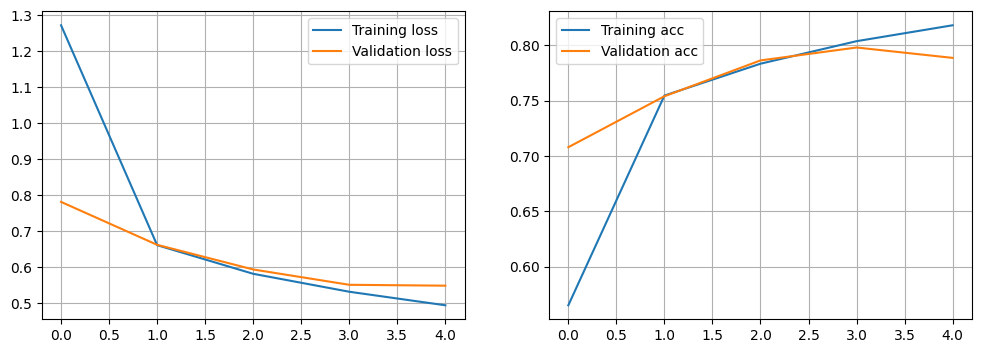

--------------------------------------------


In [11]:
n_epochs = 5
batch_size = 64
lr = 0.01
model = cnn_model()

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, n_epochs, training_loader,
                                                                validation_loader, verbose=True)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [12]:
def cross_validate(network, k_folds, batch_size, optimizer, loss_function, dataset, num_epochs=1, verbose=False):
    # Initialize the k-fold cross validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=4)
    cross_validation_results = {}

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

        # Print
        if verbose:
            print('--------------------------------')
            print(f'FOLD {fold + 1}')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)
        # Move to device
        trainloader = [(data.to(device), target.to(device)) for data, target in trainloader]
        testloader = [(data.to(device), target.to(device)) for data, target in testloader]

        # Run the training loop for defined number of epochs
        for epoch in range(0, num_epochs):
            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):
                # Get inputs
                inputs, targets = data
                # Zero the gradients
                optimizer.zero_grad()
                # Perform forward pass
                outputs = network(inputs)
                # Compute loss
                loss = loss_function(outputs, targets)
                # Perform backward pass
                loss.backward()
                # Perform optimization
                optimizer.step()
                # Print statistics
                current_loss += loss.item()
                if verbose:
                    if i % 500 == 499:
                        print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
                        current_loss = 0.0
        # Evaluation for this fold
        if verbose:
            print('Starting testing')
        correct, total = 0, 0
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                # Generate outputs
                outputs = network(inputs)
                # Set total and correct
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            # Print accuracy
            if verbose:
                print('Accuracy for fold %d: %d%%' % (fold, 100.0 * correct / total))
            cross_validation_results[fold] = 100.0 * (correct / total)

    # Print fold results
    if verbose:
        print('-------------------------------------------------')
        print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    sum = 0.0
    for key, value in cross_validation_results.items():
        if verbose:
            print(f'Fold {key}: {value:.3f} %')
        sum += value
    avg_accuracy = sum / len(cross_validation_results.items())
    print(f'Average over all folds: {avg_accuracy:.3f} %')
    return avg_accuracy

In [13]:
dataset = ConcatDataset([training_data, validation_data])

avg = cross_validate(network=model, k_folds=5, batch_size=64, optimizer=torch.optim.SGD(model.parameters()),
                     loss_function=nn.CrossEntropyLoss(), dataset=dataset, verbose=True)

--------------------------------
FOLD 1
Loss after mini-batch   500: 0.448
Starting testing
Accuracy for fold 0: 83%
--------------------------------
FOLD 2
Loss after mini-batch   500: 0.439
Starting testing
Accuracy for fold 1: 84%
--------------------------------
FOLD 3
Loss after mini-batch   500: 0.436
Starting testing
Accuracy for fold 2: 83%
--------------------------------
FOLD 4
Loss after mini-batch   500: 0.437
Starting testing
Accuracy for fold 3: 85%
--------------------------------
FOLD 5
Loss after mini-batch   500: 0.428
Starting testing
Accuracy for fold 4: 84%
-------------------------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
Fold 0: 83.825 %
Fold 1: 84.200 %
Fold 2: 83.992 %
Fold 3: 85.108 %
Fold 4: 84.775 %
Average over all folds: 84.380 %


### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


2 - Momentum

In [14]:
k_folds = 5
batch_size = 64
loss_function = nn.CrossEntropyLoss()
dataset = ConcatDataset([training_data, validation_data])
network = cnn_model()

params = [
    # just vary momentum
    (0.9, 0.01, False), (0.5, 0.01, False), (0.1, 0.01, False),
    # vary learning rate
    (0.9, 0.005, False), (0.9, 0.05, False), (0.9, 0.025, False),
    # vary nesterov
    (0.9, 0.01, False)
]

res_dict = {}

for (momentum, lr, nesterov) in params:
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    res_dict[momentum, lr, nesterov] = cross_validate(network, k_folds, batch_size, optimizer, loss_function,
                                                      dataset, 1)

res_dict = dict(sorted(res_dict.items(), key=lambda item: item[1]))
[print(f"Params (m={mom} lr={lr} nesterov={nes}) -> Accuracy: {acc:.3f}%") for (mom, lr, nes), acc in
 res_dict.items()]

Average over all folds: 87.892 %
Average over all folds: 91.692 %
Average over all folds: 92.610 %
Average over all folds: 92.183 %
Average over all folds: 91.468 %
Average over all folds: 95.643 %
Average over all folds: 98.207 %
Params (m=0.9 lr=0.05 nesterov=False) -> Accuracy: 91.468%
Params (m=0.5 lr=0.01 nesterov=False) -> Accuracy: 91.692%
Params (m=0.9 lr=0.005 nesterov=False) -> Accuracy: 92.183%
Params (m=0.1 lr=0.01 nesterov=False) -> Accuracy: 92.610%
Params (m=0.9 lr=0.025 nesterov=False) -> Accuracy: 95.643%
Params (m=0.9 lr=0.01 nesterov=False) -> Accuracy: 98.207%


[None, None, None, None, None, None]

Best results for: (momentum=0.9 lr=0.01 nesterov=False)
Final Validation Accuracy=0.9118 Cost: 0.2439
Final Training   Accuracy=0.9287 Cost: 0.1955
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (11,), Batch: 64
Final val accuracy: 0.9118232484076433


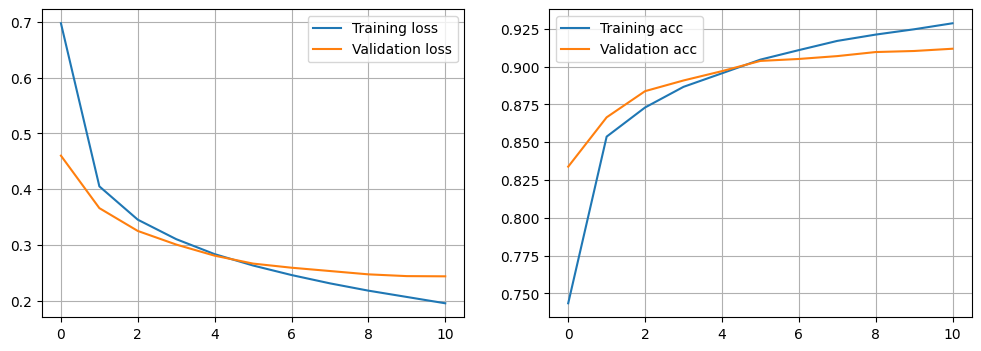

--------------------------------------------


In [15]:
n_epochs = 11
batch_size = 64
best_params = list(res_dict)[-1]
network = cnn_model()
best_params_str = f"(momentum={best_params[0]} lr={best_params[1]} nesterov={best_params[2]})"
print(f"Best results for: {best_params_str}")

best_optimizer = torch.optim.SGD(network.parameters(), momentum=best_params[0], lr=best_params[1],
                                 nesterov=best_params[2])
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(network, best_optimizer, n_epochs, training_loader,
                                                                validation_loader)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

In [16]:
# 2. Momentum
print(f"Best results with: {best_params}, in {n_epochs} epochs, with accuracy: {acc_hist_test[-1]:.3f}%")

Best results with: (0.9, 0.01, False), in 11 epochs, with accuracy: 0.912%


3 - RMSProp

In [17]:
# 3. RMSProp
k_folds = 5
batch_size = 64
num_epochs = 1
loss_function = nn.CrossEntropyLoss()
dataset = ConcatDataset([training_data, validation_data])
network = cnn_model()

params = [
    # just vary alpha
    (0.99, 0.01, False), (0.5, 0.01, False), (0.1, 0.01, False),
    # vary learning rate
    (0.99, 0.005, False), (0.99, 0.05, False), (0.99, 0.025, False),
    # vary centered
    (0.99, 0.01, False)
]

res_dict = {}

for (alpha, lr, centered) in params:
    optimizer = torch.optim.RMSprop(network.parameters(), alpha=alpha, lr=lr, momentum=0, centered=centered)
    res_dict[alpha, lr, centered] = cross_validate(network, k_folds, batch_size, optimizer, loss_function,
                                                   dataset, num_epochs)

res_dict = dict(sorted(res_dict.items(), key=lambda item: item[1]))
[print(f"Params (alpha={alpha} lr={lr} centered={centered}) -> Accuracy: {acc:.3f}%") for (alpha, lr, centered), acc in
 res_dict.items()]

Average over all folds: 88.240 %
Average over all folds: 86.688 %
Average over all folds: 83.040 %
Average over all folds: 80.828 %
Average over all folds: 9.795 %
Average over all folds: 9.897 %
Average over all folds: 9.927 %
Params (alpha=0.99 lr=0.05 centered=False) -> Accuracy: 9.795%
Params (alpha=0.99 lr=0.025 centered=False) -> Accuracy: 9.897%
Params (alpha=0.99 lr=0.01 centered=False) -> Accuracy: 9.927%
Params (alpha=0.99 lr=0.005 centered=False) -> Accuracy: 80.828%
Params (alpha=0.1 lr=0.01 centered=False) -> Accuracy: 83.040%
Params (alpha=0.5 lr=0.01 centered=False) -> Accuracy: 86.688%


[None, None, None, None, None, None]

Best results for: (alpha=0.5 lr=0.01 centered=False)
Final Validation Accuracy=0.8365 Cost: 0.5299
Final Training   Accuracy=0.8369 Cost: 0.5313
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (15,), Batch: 64
Final val accuracy: 0.836484872611465


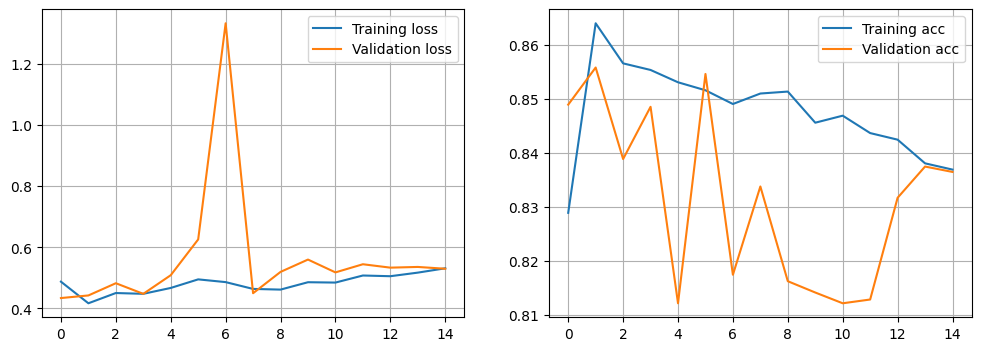

--------------------------------------------


In [18]:
n_epochs = 15
batch_size = 64
best_params = list(res_dict)[-1]
network = cnn_model()
best_params_str = f"(alpha={best_params[0]} lr={best_params[1]} centered={best_params[2]})"
print(f"Best results for: {best_params_str}")

best_optimizer = torch.optim.RMSprop(network.parameters(), alpha=best_params[0], lr=best_params[1],
                                     momentum=0, centered=best_params[2])
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(network, best_optimizer, n_epochs, training_loader,
                                                                validation_loader)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

In [19]:
# 3. Momentum
print(f"Best results with: {best_params}, in {n_epochs} epochs, with accuracy: {acc_hist_test[-1]:.3f}%")

Best results with: (0.5, 0.01, False), in 15 epochs, with accuracy: 0.836%


4 - Adam

In [20]:
# 4. Adam
k_folds = 5
batch_size = 64
num_epochs = 1
loss_function = nn.CrossEntropyLoss()
dataset = ConcatDataset([training_data, validation_data])
network = cnn_model()

params = [
    # vary learning rate
    (0, 0.0005), (0, 0.001), (0, 0.005), (0, 0.01), (0, 0.025),
    # vary weight_decay
    (0.001, 0.001), (0.005, 0.001)
]

res_dict = {}

for (weight_decay, lr) in params:
    optimizer = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=weight_decay)
    res_dict[weight_decay, lr] = cross_validate(network, k_folds, batch_size, optimizer, loss_function,
                                                dataset, num_epochs)

res_dict = dict(sorted(res_dict.items(), key=lambda item: item[1]))
[print(f"Params (weight_decay={weight_decay} lr={lr}) -> Accuracy: {acc:.3f}%") for (weight_decay, lr), acc in
 res_dict.items()]

Average over all folds: 86.877 %
Average over all folds: 90.035 %
Average over all folds: 91.912 %
Average over all folds: 91.290 %
Average over all folds: 86.587 %
Average over all folds: 91.438 %
Average over all folds: 89.343 %
Params (weight_decay=0 lr=0.025) -> Accuracy: 86.587%
Params (weight_decay=0 lr=0.0005) -> Accuracy: 86.877%
Params (weight_decay=0.005 lr=0.001) -> Accuracy: 89.343%
Params (weight_decay=0 lr=0.001) -> Accuracy: 90.035%
Params (weight_decay=0 lr=0.01) -> Accuracy: 91.290%
Params (weight_decay=0.001 lr=0.001) -> Accuracy: 91.438%
Params (weight_decay=0 lr=0.005) -> Accuracy: 91.912%


[None, None, None, None, None, None, None]

Best results for: (weight_decay=0 lr=0.005)
Final Validation Accuracy=0.9105 Cost: 0.2952
Final Training   Accuracy=0.9360 Cost: 0.1693
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (6,), Batch: 64
Final val accuracy: 0.9105294585987261


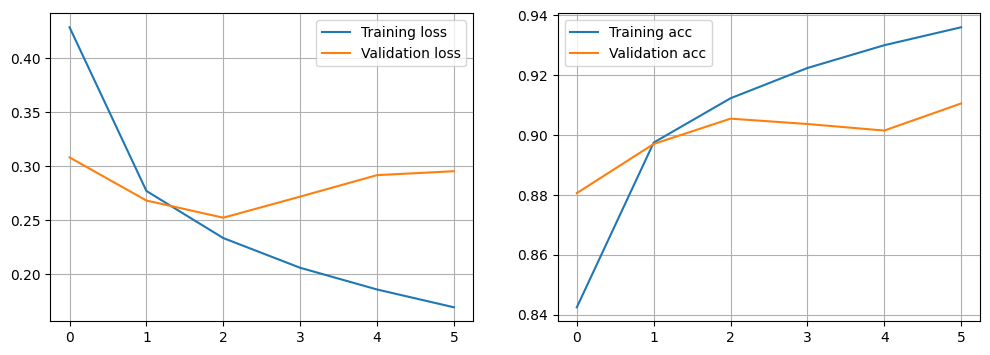

--------------------------------------------


In [21]:
n_epochs = 6
batch_size = 64
best_params = list(res_dict)[-1]
network = cnn_model()
best_params_str = f"(weight_decay={best_params[0]} lr={best_params[1]})"
print(f"Best results for: {best_params_str}")

best_optimizer = torch.optim.Adam(network.parameters(), weight_decay=best_params[0], lr=best_params[1])
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(network, best_optimizer, n_epochs, training_loader,
                                                                validation_loader)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

In [22]:
# 4. Adam
print(f"Best results with: {best_params}, in {n_epochs} epochs, with accuracy: {acc_hist_test[-1]:.3f}%")

Best results with: (0, 0.005), in 6 epochs, with accuracy: 0.911%


### Plots and Comments (for the different steps described above) 

The best overall performance was delivered by the adam optimizer

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.

Final Validation Accuracy=0.8277 Cost: 0.4875
Final Training   Accuracy=0.8347 Cost: 0.4729
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (55,), Batch: 64
Final val accuracy: 0.8277269108280255


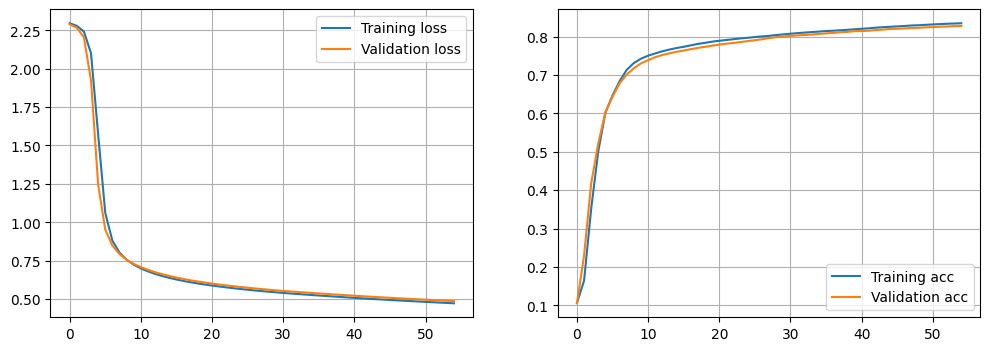

--------------------------------------------


In [24]:
n_epochs = 55
batch_size = 64
lr = 0.001
model = cnn_model()

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, n_epochs, training_loader,
                                                                validation_loader, scheduler)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()